In [7]:
from search_clustering.utils.odp_239 import read_odp239_to_df
from evaluate_odp import read_results
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [172]:
df = read_odp239_to_df()
categories = df["category"].unique()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/c.brueckner/Projects/masterthesis/search_clustering/utils/../../datasets/odp-239/docs.txt'

# Documents per Category

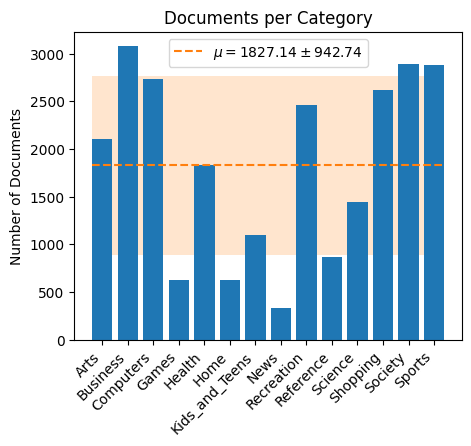

In [2]:
docs_per_category = df.groupby("category").count()["docID"]

mean = round(np.mean(docs_per_category), 2)
std = round(np.std(docs_per_category), 2)

fix, ax = plt.subplots(figsize=(5, 4))

rect = plt.Rectangle((-0.4, mean - std), 13.8, 2 * std, facecolor="C1", alpha=0.2)
ax.add_patch(rect)

ax.bar(categories, docs_per_category)
ax.hlines(
    mean,
    -0.4,
    13.4,
    linestyles="dashed",
    color="C1",
    label=rf"$\mu = {mean} \pm {std}$",
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Documents")
plt.title("Documents per Category")
plt.legend()
plt.show()

# Topics per Category

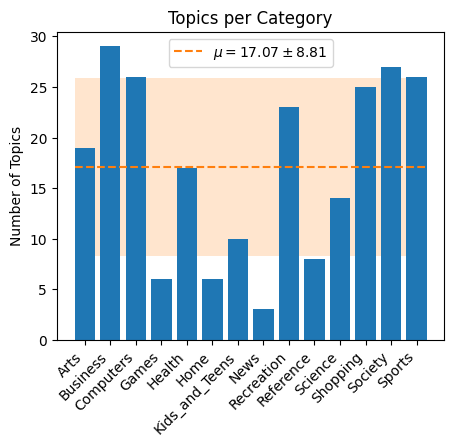

In [3]:
topics_per_category = df.groupby("category").nunique()["topic"]

mean = round(np.mean(topics_per_category), 2)
std = round(np.std(topics_per_category), 2)

fig, ax = plt.subplots(figsize=(5, 4))

rect = plt.Rectangle((-0.4, mean - std), 13.8, 2 * std, facecolor="C1", alpha=0.2)
ax.add_patch(rect)

ax.bar(categories, topics_per_category)
ax.hlines(
    mean,
    -0.4,
    13.4,
    linestyles="dashed",
    color="C1",
    label=rf"$\mu = {mean} \pm {std}$",
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Topics")
plt.title("Topics per Category")
plt.legend()
plt.show()

In [4]:
np.corrcoef(docs_per_category, topics_per_category)

array([[1.        , 0.99892925],
       [0.99892925, 1.        ]])

# Documents per Topic

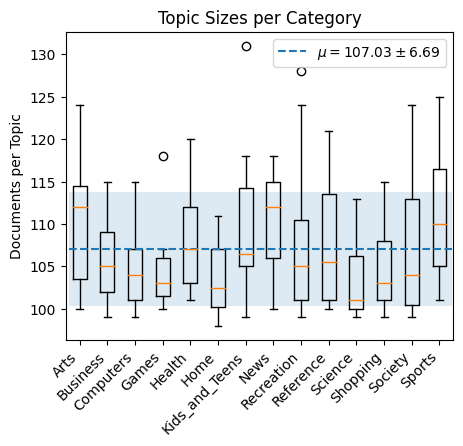

In [5]:
topic_counts = []

for i in range(len(categories)):
    category = categories[i]
    df_cat = df[df.category == category]
    topics = df_cat["topic"].unique()

    topic_counts_cat = df_cat.groupby(["topic"]).count()["docID"]
    topic_counts.append(topic_counts_cat.tolist())

flat_counts = [count for category in topic_counts for count in category]
mean = round(np.mean(flat_counts), 2)
std = round(np.std(flat_counts), 2)

fig, ax = plt.subplots(figsize=(5, 4))

rect = plt.Rectangle((0.6, mean - std), 13.85, 2 * std, facecolor="C0", alpha=0.15)
ax.add_patch(rect)

ax.boxplot(topic_counts, labels=categories)
ax.hlines(107.0293, 0.6, 14.45, linestyles="dashed", label=rf"$\mu = {mean} \pm {std}$")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Documents per Topic")
plt.title("Topic Sizes per Category")
plt.legend()
plt.show()

# Tokens per Document

In [6]:
counts_per_title = []
counts_per_snippet = []

title_lengths = [len(word_tokenize(title)) for title in df["title"]]
snippet_lengths = [len(word_tokenize(snippet)) for snippet in df["snippet"]]

counts_per_title.extend(title_lengths)
counts_per_snippet.extend(snippet_lengths)
counts_per_doc = [counts_per_title[i] + counts_per_snippet[i] for i in range(len(df))]

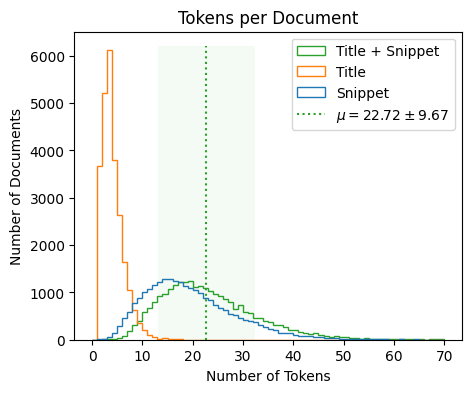

In [7]:
median = round(np.median(counts_per_doc), 2)
mean = round(np.mean(counts_per_doc), 2)
std = round(np.std(counts_per_doc), 2)

bins = 70

fig, ax = plt.subplots(figsize=(5, 4))

rect = plt.Rectangle((mean - std, 0), 2 * std, 6200, facecolor="C2", alpha=0.05)
ax.add_patch(rect)

ax.hist(
    [counts_per_snippet, counts_per_title, counts_per_doc],
    bins=bins,
    range=(0, bins),
    alpha=1,
    histtype="step",
    label=["Snippet", "Title", "Title + Snippet"],
)
ax.vlines(
    mean, 0, 6200, color=["C2"], linestyles="dotted", label=rf"$\mu = {mean} \pm {std}$"
)

plt.xlabel("Number of Tokens")
plt.ylabel("Number of Documents")
plt.title("Tokens per Document")
plt.legend()
plt.show()

# Execution Times

In [164]:
t_cpu = read_results("evaluation_odp_cpu.json")["time"]
t_gpu = read_results("evaluation_odp_gpu.json")["time"]
t_cached = read_results("evaluation_odp_gpu_cached.json")["time"]

times = pd.concat([t_cpu, t_gpu, t_gpu_c], axis=1)
times.columns=["CPU", "GPU", "GPU (cached)"]
times.loc[[("Col2Vec", "KMeans", "Umap8"), ("SentenceMiniLM", "DBSCAN", "Umap8")]]

,,,CPU,GPU,GPU (cached)
embedding,clustering,reduction,,,
Col2Vec,KMeans,Umap8,15.8 ± 8.55,8.77 ± 4.68,NaN
SentenceMiniLM,DBSCAN,Umap8,823.6 ± 427.23,39.18 ± 20.33,7.67 ± 4.18


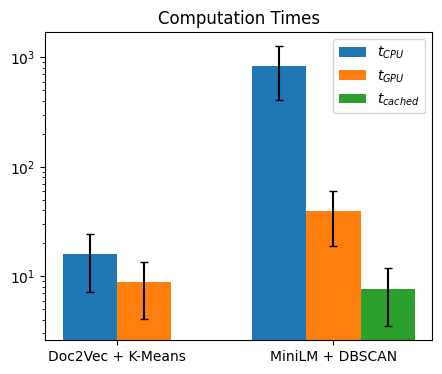

In [161]:
width = 0.25
capsize=3

cpu_ticks = [1 - width / 2, 2 - width]
cpu_heights = [15.8, 832.6]
gpu_ticks = [1 + width / 2, 2]
gpu_heights = [8.77, 39.18]
cache_ticks = [2 + width]

fig, ax = plt.subplots(figsize=(5, 4))

ax.bar(cpu_ticks, cpu_heights, width=width, label=r"$t_{CPU}$")
ax.bar(gpu_ticks, gpu_heights, width=width, label=r"$t_{GPU}$")
ax.bar(cache_ticks, [7.67], width=width, label=r"$t_{cached}$")

ax.errorbar(cpu_ticks, cpu_heights, [8.55, 427.23], color="black", linestyle="None", capsize=capsize)
ax.errorbar(gpu_ticks, gpu_heights, [4.68, 20.33], color="black", linestyle="None", capsize=capsize)
ax.errorbar(cache_ticks, [7.67], [4.18], color="black", linestyle="None", capsize=capsize)

ax.set_xticks([1,2], labels=["Doc2Vec + K-Means", "MiniLM + DBSCAN"])
ax.set_yscale("log")
plt.legend()
plt.title("Computation Times")

plt.show()

# Performance vs Time

In [ ]:
plt.errorbar([2.08, 39.18], 